# Time Series Forecasting with Neural Network Model: S&P 500 index

## Goal: Predict Open / Close Price of the date

## Steps
* Get data: Get data from yahoo finance (last 5 years)
* 

In [70]:
import pandas_datareader as pdr
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [71]:
# Import S&P 500 index from Yahoo Finance
df=pdr.get_data_yahoo('^GSPC', )

In [72]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-07-31,2477.959961,2468.530029,2475.939941,2470.300049,3469210000,2470.300049
2017-08-01,2478.510010,2471.139893,2477.100098,2476.350098,3460860000,2476.350098
2017-08-02,2480.379883,2466.479980,2480.379883,2477.570068,3478580000,2477.570068
2017-08-03,2476.030029,2468.850098,2476.030029,2472.159912,3645020000,2472.159912
2017-08-04,2480.000000,2472.080078,2476.879883,2476.830078,3235140000,2476.830078


# Feature definitions
* Date: Date of interest
* High: Highest index within the day
* Low : Lowest index within the day
* Close: Closing index of the date
* Volume: How many shares have traded within the day
* Adj Close: Closing price after adjustments for all applicable splits and dividend distributions

In [73]:
len(df[df['Close']!=df['Adj Close']])

0

In [74]:
# Drop the Adj Close column because it is the same as the Close column
df = df[['Open','Close']]

In [75]:
df.head()

,Open,Close
Date,,
2017-07-31,2475.939941,2470.300049
2017-08-01,2477.100098,2476.350098
2017-08-02,2480.379883,2477.570068
2017-08-03,2476.030029,2472.159912
2017-08-04,2476.879883,2476.830078


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2017-07-31 to 2022-07-29
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1259 non-null   float64
 1   Close   1259 non-null   float64
dtypes: float64(2)
memory usage: 29.5 KB


# Exploratory Data Analysis and Feature Engineering

## EDA
* Check for missing data
* Visualize

In [77]:
df.isnull().sum()

Open     0
Close    0
dtype: int64

Text(0.5, 1.0, 'S&P 500 Index Open Price')

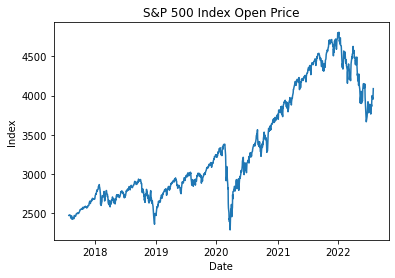

In [78]:
plt.figure()
plt.plot(df['Open'],color='tab:blue')
plt.xlabel('Date')
plt.ylabel('Index')
plt.title('S&P 500 Index Open Price')

Text(0.5, 1.0, 'S&P 500 Index Close Price')

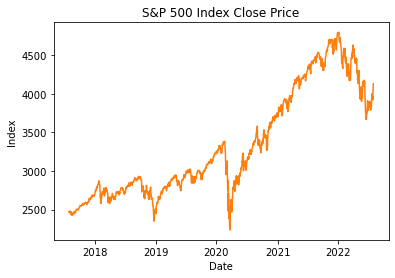

In [79]:
plt.figure()
plt.plot(df['Close'],color='tab:orange')
plt.xlabel('Date')
plt.ylabel('Index')
plt.title('S&P 500 Index Close Price')

Text(0.5, 1.0, 'Absolute value of Close Price - Open Price')

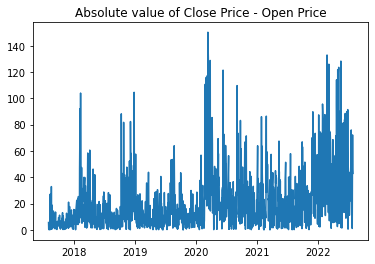

In [80]:
plt.figure()
plt.plot(abs(df['Close']-df['Open']))
plt.title('Absolute value of Close Price - Open Price')

In [81]:
(df['Close']-df['Open']).abs().mean()

21.83323197974583

In [82]:
(df['Close']-df['Open']).abs().std()

23.654846560213198

## Feature Engineering
* Take Open and Close prices from the dataset


* Scale the data: MinMaxScaler
* Take first 80% for training set
* Take the most recent 30 days for evaluation set
* Left over: test set


* Convert data to a model-feedable form
* Model: Use LSTM. (Advanced version of RNN; specialized in predict future value based on past data)
* Predict the price based on past 30 days: Feed 2D tensor to each date (overall data format will be 3D tensor; date x 30days x features)

### Why MinMax over Standard scaler?
* The price value itself is more relevant than the distribution (Z-score)

## Reference
* I found Colah's post is very helpful for understanding how LSTM performs. I HIGHLY recommend checking this post http://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [83]:
# Define a function that reframe data (include past 30 days data)
def make_sequential_data(X,num_timesteps):
    """
    Take data X, len_days (number of past days to make a model out of)
    i-th date: data should be 2-D tensor for a day. len_days rows
    The overall data will be (date x num_timesteps x num_features) 3-D tensor
    """
    data=[]
    y=[]
    X = np.array(X)
    for i in range(num_timesteps, len(X)): # range: start point inclusive, end point exclusive (i=30 ~ len(X)-1)
        data.append(X[i-num_timesteps:i]) # -30 days to current date, 2 features
        y.append(X[i])
    return np.array(data), np.array(y)

## Scale and Split data (80% training, 10% test, last 10 % for evaluation)
* Make a temporal test data set just to get the statistics to scale the data: prevent leakage from future information
* Check the shape of the re-framed dataset: (num_data, num_timestepts=30, num_features=2)

In [106]:
X_train = df[:int(0.8*len(df))]
len(X_train)

1007

In [101]:
from sklearn.preprocessing import MinMaxScaler

In [102]:
scaler = MinMaxScaler()
scaler.fit(X_train)

MinMaxScaler()

In [103]:
scaled_data = scaler.transform(df)

In [104]:
X, y = make_sequential_data(scaled_data, 30)

In [105]:
print(len(df), len(X))

1259 1229


In [113]:
X_train = X[:int(0.8*len(df))-30]
y_train = y[:int(0.8*len(df))-30]
print(X_train.shape, y_train.shape) # Should have 30 fewer datapoints because first 30 rows were removed from the make_sequential function

(977, 30, 2) (977, 2)


In [114]:
X_test = X[int(0.8*len(df))-30:-30]
y_test = y[int(0.8*len(df))-30:-30]
print(X_test.shape, y_test.shape)

(222, 30, 2) (222, 2)


In [115]:
X_eval = X[-30:]
y_eval = y[-30:]
print(X_eval.shape, y_eval.shape)

(30, 30, 2) (30, 2)


## Model & Prediction

In [123]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

### Open Price prediction model
* Single LSTM layer model
* Double LSTM layer model
* Test under variant cell number

#### Reference: input data shape
https://stackoverflow.com/questions/61153831/how-to-properly-set-the-input-shape-of-lstm-layers

In [236]:
def single_layer_model(X_train, X_test, y_train, y_test, num_cells, epochs):
    model = Sequential()
    # Input shape should be (num_timesteps, num_features)
    model.add(LSTM(units=num_cells, activation='tanh', input_shape=X_train[0].shape)) 
    model.add(Dense(2)) # Return two values: "Open" and "Close"
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Early stop condition: no improve for next 10 points
    early_stop = EarlyStopping(monitor="val_loss", patience=10)
    model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), callbacks=[early_stop], verbose=0)
    return model

In [226]:
def double_layer_model(X_train, X_test, y_train, y_test, num_cells, epochs):
    model = Sequential()
    # Input shape should be (num_timesteps, num_features)
    model.add(LSTM(units=num_cells, activation='tanh', input_shape=X_train[0].shape, return_sequences=True))
    model.add(LSTM(units=num_cells, activation='tanh', input_shape=X_train[0].shape, return_sequences=False))
    model.add(Dense(2)) # Return two values: "Open" and "Close"
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Early stop condition: no improve for next 10 points
    early_stop = EarlyStopping(monitor="val_loss", patience=10)
    model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), callbacks=[early_stop], verbose=0)
    return model

In [233]:
def model_evaluation(model):
    fig = plt.figure(figsize=(16,8))
    ax1=fig.add_axes([0.2,0.1,0.7,0.35])
    ax2=fig.add_axes([0.2,0.55,0.7,0.35])
    ax1.plot(df['Open'].iloc[-35:],color='tab:blue', label="Real Open Price")
    ax1.plot(df['Close'].iloc[-35:], color='tab:orange', label="Real Close Price")
    ax1.plot(df.index[-30:],y_pred_eval[:,0],color='tab:blue',linestyle='--', label="Predicted Open Price")
    ax1.plot(df.index[-30:],y_pred_eval[:,1],color='tab:orange',linestyle='--', label="Predicted Close Price")
    plt.xticks(rotation=90)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Index')
    ax1.set_title('S&P 500 Index Price')
    ax1.legend()
    
    ax2.plot(model.history.history['loss'], label='Train Loss')
    ax2.plot(model.history.history['val_loss'], label='Test Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('MSE')
    ax2.legend()

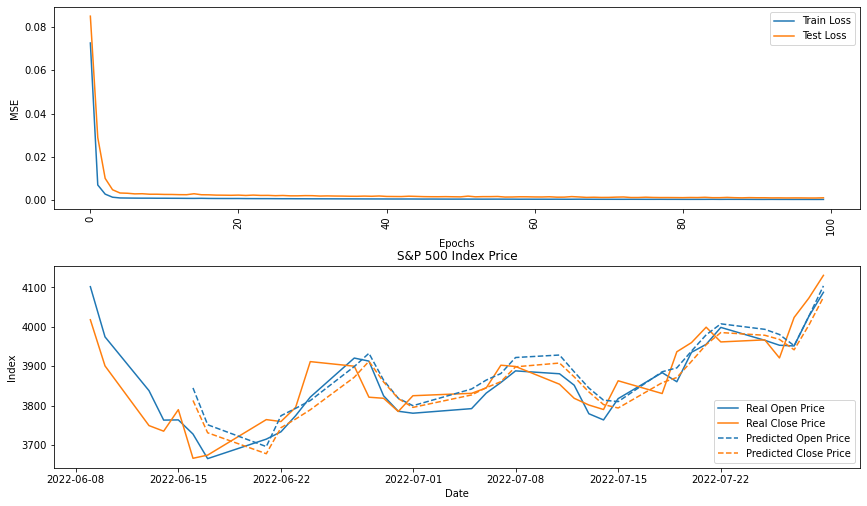

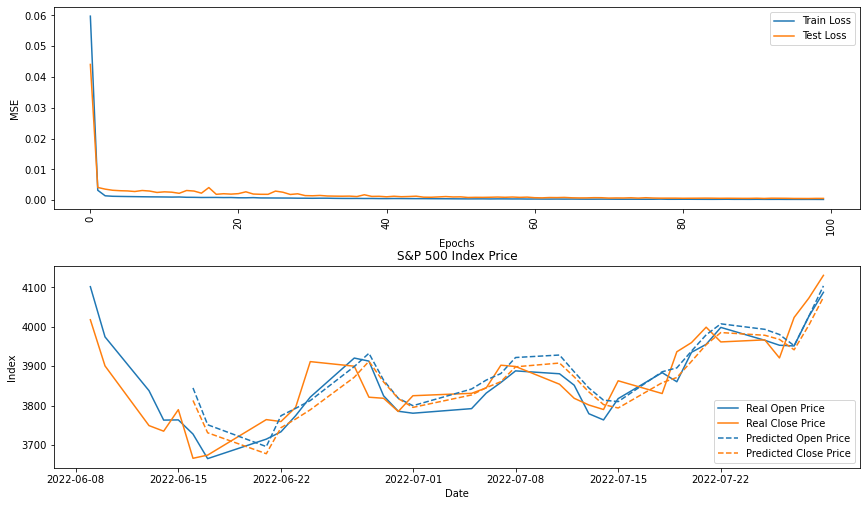

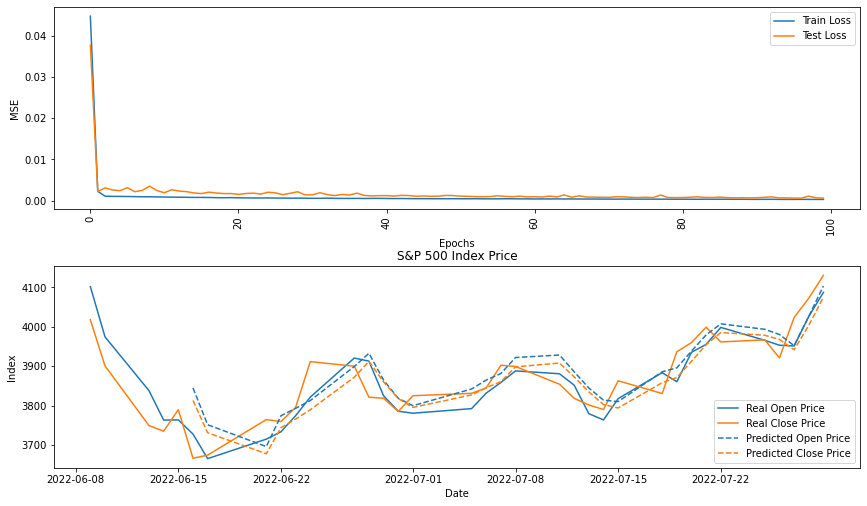

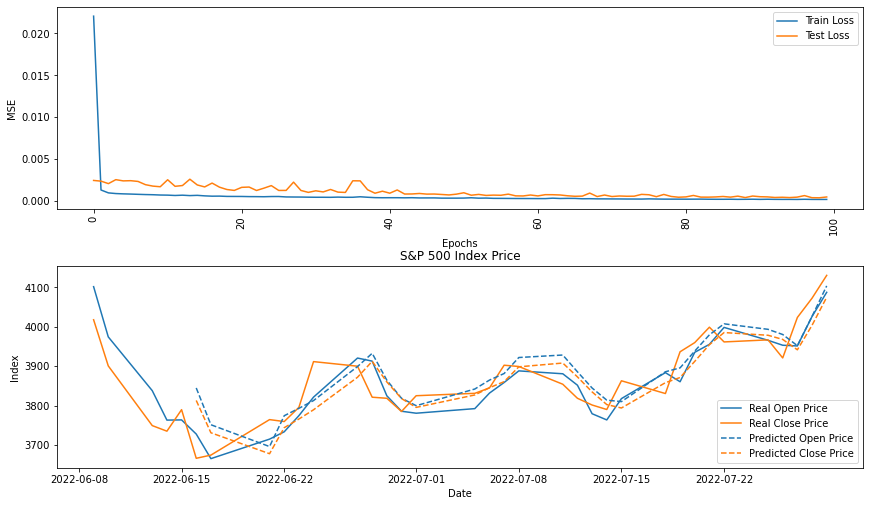

In [237]:
for num_cells in [16,32,64,128]:
    model = single_layer_model(X_train, X_test, y_train, y_test, num_cells, epochs=100)
    model_evaluation(model)